In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import my_statistics as ms
import seaborn as sns
from sklearn import tree
from tqdm.notebook import tqdm
import copy
import decision_trees as dt
import random

In [2]:
hitters = pd.read_csv('Gradivo/Hitters.csv')

In [3]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
hitters.shape

(322, 20)

In [5]:
hitters.dropna(axis=0, subset=['Salary'], inplace=True)

In [6]:
hitters.shape

(263, 20)

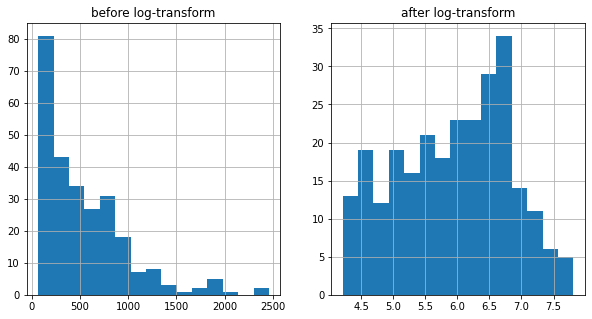

In [7]:
# salary log transform
salary_log = np.log(hitters.Salary)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(x = hitters.Salary, bins=15)
ax[0].set_title('before log-transform')
ax[0].grid()
ax[1].hist(x = salary_log, bins=15)
ax[1].set_title('after log-transform')
ax[1].grid()

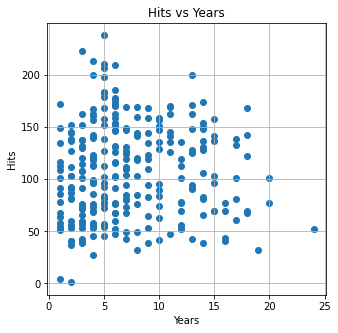

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(hitters.Years, hitters.Hits)
plt.title('Hits vs Years')
plt.xlabel('Years')
plt.ylabel('Hits')
plt.grid()

###  Recursice binary splitting

In [9]:
hitters.head(1)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N


In [10]:
hitters_num = hitters.loc[:,hitters.dtypes == 'int64']

In [11]:
hitters_num.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')

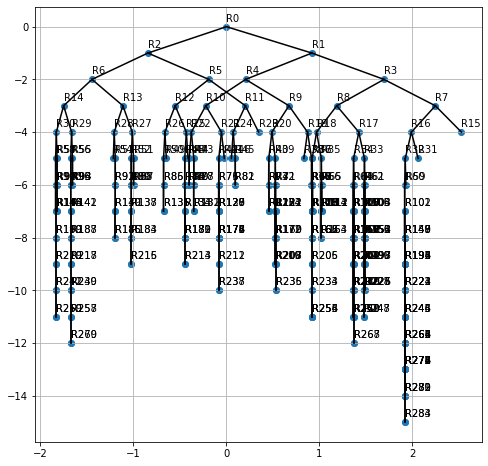

In [12]:
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
r_size=3
my_tree, y_ref_vals, y_classified, heritage = dt.decision_tree(hitters_num[features],
                                                            salary_log,
                                                            s_partitions=30,
                                                            R_size_max=r_size,
                                                           plot_ = True)

In [13]:
pred, cl_pred = dt.predict(hitters_num[features], my_tree, y_ref_vals)

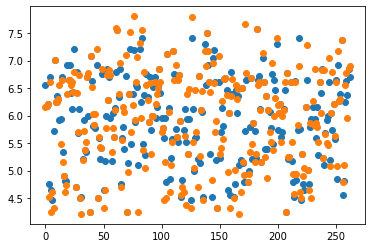

In [14]:
plt.plot(np.arange(len(pred)), pred,'o')
plt.plot(np.arange(len(pred)), salary_log,'o')
#plt.xlim(0,50)

In [21]:
# predictions for different R size limits
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
errors, predictions, refs = {}, {}, {}
r_list = [50, 30, 10, 5, 3]
for r_size in tqdm(r_list):
    my_tree, y_ref_vals, y_class, heritage_ = dt.decision_tree(hitters_num[features], salary_log, s_partitions=30, R_size_max=r_size)
    y_pred, y_cl = dt.predict(hitters_num[features], my_tree, y_ref_vals)
    dif = abs(salary_log - y_pred)
    errors[r_size] = dif
    predictions[r_size] = y_pred
    refs[r_size] = np.array(salary_log)

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, 'MSE')

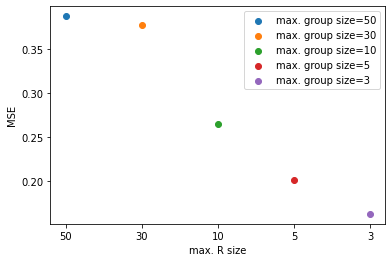

In [23]:
# MSE for different R size limits
for i,j in enumerate(r_list):
    plt.scatter(i, ms.MSE(np.array(predictions[j]), np.array(refs[j])),
                label=f'max. group size={j}')
plt.xticks(np.arange(len(r_list)), r_list)
plt.legend()
plt.xlabel('max. R size')
plt.ylabel('MSE')

(0.0, 100.0)

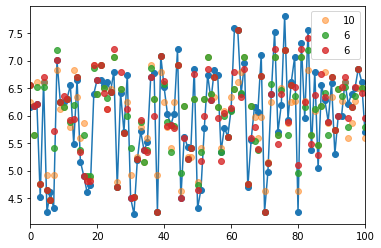

In [28]:
# predictions for different R sizes
plt.plot(np.arange(len(refs[50])), refs[50],'-o')
#plt.plot(np.arange(len(predictions[50])), predictions[50],'o', label=50)
#plt.plot(np.arange(len(predictions[30])), predictions[30], 'o', label=30,alpha=.5)
plt.plot(np.arange(len(predictions[10])), predictions[10], 'o', label=10, alpha=.5)
plt.plot(np.arange(len(predictions[5])), predictions[5], 'o', label=6, alpha=.8)
plt.plot(np.arange(len(predictions[3])), predictions[3], 'o', label=6, alpha=.8)
plt.legend()
plt.xlim(0,100)

### Determining $\alpha$ values and treesizes for tree pruning purpuses

In [15]:
tree_scores_alpha = []
alpha_l = []
tree_sizes_l = []
alpha_array = np.linspace(0,2,10)
for alpha in tqdm(alpha_array):
    tree_scores, tree_sizes = dt.tree_pruning(y_classified, y_ref_vals, heritage, alpha=alpha, all_=True)
    alpha_l.append(alpha)
    tree_scores_alpha.append(tree_scores)
    tree_sizes_l.append(tree_sizes)

  0%|          | 0/10 [00:00<?, ?it/s]

α_0; tree score min = 41.471110302678454, tree size = 143
α_1; tree score min = 73.12860534892049, tree size = 141
α_2; tree score min = 92.85252411010605, tree size = 16
α_3; tree score min = 96.4080796656616, tree size = 16
α_4; tree score min = 99.96363522121715, tree size = 16
α_5; tree score min = 103.51919077677272, tree size = 16
α_6; tree score min = 107.07474633232826, tree size = 16
α_7; tree score min = 109.24230694056024, tree size = 4
α_8; tree score min = 110.13119582944913, tree size = 4
α_9; tree score min = 111.02008471833801, tree size = 4


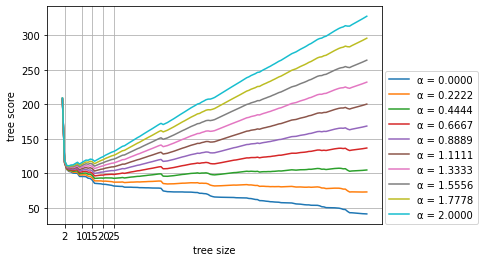

In [16]:
for i,j in enumerate(alpha_l):
    plt.plot(tree_sizes_l[i], tree_scores_alpha[i], label=f'α = {j:.4f}')
    min_ind = np.argmin(tree_scores_alpha[i])
    print(f'α_{i}; tree score min = {tree_scores_alpha[i][min_ind]}, tree size = {tree_sizes_l[i][min_ind]}')
plt.legend(loc = (1.01, 0))
plt.ylabel('tree score')
plt.xlabel('tree size')
plt.xticks(ticks=[2,10,15,20,25])
plt.grid()


In [29]:
# find alphas and corresponding tree sizes
alphas, sizes = dt.find_alphas(y_classified, y_ref_vals, heritage, np.linspace(0,2,10))

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
len(dt.shrink_tree(my_tree, y_classified, y_ref_vals, heritage, size_goal=sizes[3])[0])

4

In [25]:
def k_fold_split(input_, output_, k):
    indices = list(np.arange(input_.shape[0], dtype=int))
    fold_size = int(input_.shape[0]/k)
    input_folds = []
    output_folds = []
    for i in range(k-1):
        k_ind = np.zeros(fold_size, dtype=int)
        for j in range(fold_size):
            k_ind[j] = random.choice(indices)
            indices.remove(k_ind[j])
        input_folds.append(np.array(input_[k_ind]))
        output_folds.append(np.array(output_[k_ind]))
    input_folds.append(input_[indices])
    output_folds.append(output_[indices])
    return input_folds, output_folds

In [39]:
def k_fold_CV_for_decision_tree_pruning(inputs_, outputs_,alpha,
                                        sizes, k=10,
                                        find_alpha_opt=False, r_size=10,
                                       ):
    # data split
    input_f, output_f = k_fold_split(np.array(inputs_), np.array(outputs_), k=k)
    error_rates = []
    for alpha_ind, k_ in enumerate(tqdm(alpha, desc=f'Main loop')):
        errors = []
        for i in tqdm(range(k), desc=f'loop for α = {k_:.4}: ', leave=False):
            pred_fold_ = pd.DataFrame(input_f[i])
            ref_fold_ = output_f[i]
            ind_list = list(np.arange(k))
            ind_list.remove(i)
            input_folds_ = np.array(input_f, dtype=object)[ind_list]
            input_folds_ = np.concatenate(input_folds_.squeeze(),axis=0)
            output_folds_ =np.array(output_f, dtype=object)[ind_list]
            output_folds_ = np.concatenate(output_folds_.squeeze(),axis=0)
            input_f_df = pd.DataFrame(input_folds_)
            output_f_s = pd.Series(output_folds_)
            # form the decision tree for k-th fold
            my_tree, y_ref_vals, y_classified, heritage = dt.decision_tree(input_f_df,
                                                            output_f_s,
                                                            s_partitions=30,
                                                            R_size_max=r_size,
                                                           plot_ = False)
            # shrink the tree for current α
            my_tree, y_ref_vals = dt.shrink_tree(my_tree, y_classified,
                                                y_ref_vals, heritage, size_goal=sizes[alpha_ind])
            y_pred, cl_pred = dt.predict(pred_fold_, my_tree, y_ref_vals)
            errors.append(ms.RSS(y_pred, ref_fold_))
        error_rates.append(np.average(errors))
    if find_alpha_opt:
        alpha_opt = alpha[np.argmin(np.array(error_rates))]
        return error_rates, K_opt
    return error_rates

In [42]:
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
r_size=10
errors =  k_fold_CV_for_decision_tree_pruning(hitters_num[features], 
                                    salary_log, k=8, alpha=alphas,
                                    sizes=sizes,
                                    r_size=r_size)

Main loop:   0%|          | 0/4 [00:00<?, ?it/s]

loop for α = 0.0:   0%|          | 0/8 [00:00<?, ?it/s]

loop for α = 0.2222:   0%|          | 0/8 [00:00<?, ?it/s]

loop for α = 0.4444:   0%|          | 0/8 [00:00<?, ?it/s]

loop for α = 1.556:   0%|          | 0/8 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x2813b130340>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

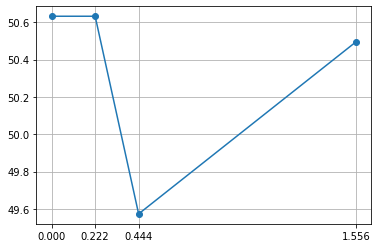

In [44]:
plt.plot(alphas, errors, '-o')
plt.grid()
plt.xticks(alphas)

Najnižjo napako dobimo, ko je alfa enaka 0.444. Pripadajoča velikost drevesa je 16

In [47]:
my_tree, y_ref_vals, y_classified, heritage = dt.decision_tree(hitters_num[features],
                                                            salary_log,
                                                            s_partitions=30,
                                                            R_size_max=r_size,
                                                           plot_ = False)
            # shrink the tree for current α
my_tree, y_ref_vals = dt.shrink_tree(my_tree, y_classified, y_ref_vals,
                                     heritage, size_goal=sizes[2])
y_pred, cl_pred = dt.predict(hitters_num[features], my_tree, y_ref_vals)

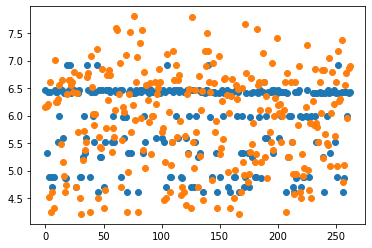

In [48]:
plt.plot(np.arange(len(y_pred)), y_pred,'o')
plt.plot(np.arange(len(y_pred)), salary_log,'o')
#plt.xlim(0,50)

##### Decision trees using sklearn

In [ ]:
reg_tree = tree.DecisionTreeRegressor()

In [ ]:
reg_tree_fit = reg_tree.fit(hitters_num, hitters.Salary)

In [ ]:
sklearn_pred = reg_tree_fit.predict(hitters_num)


In [ ]:
plt.plot(np.arange(131), reg_tree_fit.predict(hitters_num[1::2]),'-o')
plt.plot(np.arange(131),hitters.Salary[1::2],'o')
plt.plot(np.arange(131), reg_tree_fit.predict(hitters_num[1::2])- hitters.Salary[1::2])

In [ ]:
(ms.MSE(np.array(predictions[50]), np.array(refs[50])),ms.MSE(np.array(predictions[30]), np.array(refs[30])),ms.MSE(np.array(predictions[10]), np.array(refs[10])))

In [ ]:
reg_tree_fit.predict(hitters_num[1::2]).shape

In [ ]:
hitters_num[1::2].shape

In [ ]:
hitters.Salary[1::2].shape